In [19]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import uproot3 as uproot
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
max=np.max
import seaborn as sns
from sklearn.decomposition import PCA
import os
import sys
from scipy.optimize import curve_fit
from scipy.integrate import quad

import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

# Method 1

In [77]:
floc='/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v9/systematic_v24/SOURCE_FcalBcal/systematic_syst/barlows.csv'

In [78]:
df=pd.read_csv(floc)

In [79]:
df.columns

Index(['tbin', 't', 'variation', 'class', 'posNom', 'negNom', 'posVar',
       'negVar', 'nBarlowPos', 'diffPos', 'percDiffPos', 'nBarlowNeg',
       'diffNeg', 'percDiffNeg', 'yields', 'status'],
      dtype='object')

In [80]:
df['t']=df['t'].astype(str)

In [81]:
pos=df[['t','variation','nBarlowPos','percDiffPos']].groupby('t')['percDiffPos'].agg([max]).reset_index()

In [82]:
neg=df[['t','variation','nBarlowNeg','percDiffNeg']].groupby('t')['percDiffNeg'].agg([max]).reset_index()

In [83]:
pos=pos.rename({'amax':'pos'},axis=1)
pos['neg']=neg['amax']

In [84]:
pos

,t,pos,neg
0,0.1501,0.09613,0.11815
1,0.256,0.09791,0.13287
2,0.4038,0.09885,0.09342
3,0.6198,0.07760,0.09350
4,0.8691,0.09982,0.10951


# Method 2

In [29]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

In [30]:
cols=["Mpi0eta","Meta","Mpi0","mandelstam_t","Ebeam",
      'cosTheta_eta_hel','cosTheta_eta_gj',
       "weightASBS","AccWeight","weightBSpi0","weightBSeta",
       "Metap","Mpi0p",'rfTime',
      'proton_z','proton_momentum','unusedEnergy','unusedShowers','pVH','chiSq','photonTheta1','photonTheta2','photonTheta3','photonTheta4',
      'photonE1','photonE2','photonE3','photonE4','mmsq',
      'run','event',
      'Ebeam_thrown','Mpi0eta_thrown',
      'isCorrectBeam','isCorrectSpect','isCorrectCombo',
      'photonSystem1','photonSystem2','photonSystem3','photonSystem4'
     ]

baseDir='/d/grid17/ln16/dselector_v3/phase1_selected_v4'
dat_df=[]
acc_df=[]
for run in ["2017_1","2018_1","2018_8"]:
    dat_df.append(loadDF(f"{baseDir}/D{run}_selected_wUnusedShowers_acc_flat.root","kin",cols))
    acc_df.append(loadDF(f"{baseDir}/F{run}_selected_wUnusedShowers_acc_flat.root","kin",cols))
dat_df=pd.concat(dat_df)
acc_df=pd.concat(acc_df)

In [33]:
def applyCut(df,sectionStr):
    tmp=df
    vars1=sectionStr.split(" ")[::3]
    mins1=[float(x) for x in sectionStr.split(" ")[1::3]]
    maxs1=[float(x) for x in sectionStr.split(" ")[2::3]]
    
    for var1,min1,max1 in zip(vars1,mins1,maxs1):
        if var1[0]=='!':
            var1=var1[1:]
            tmp=tmp[~((tmp[var1]>min1)&(tmp[var1]<max1))]
        else:
            tmp=tmp[((tmp[var1]>min1)&(tmp[var1]<max1))]
    return tmp

selection='Mpi0eta 1.04 1.72 pVH 0.5 999 mandelstam_t 0.1 1.0 !photonTheta1 -999 2.5 !photonTheta1 10.3 11.9 !photonTheta2 -999 2.5 !photonTheta2 10.3 11.9 \
!photonTheta3 -999 2.5 !photonTheta3 10.3 11.9 !photonTheta4 -999 2.5 !photonTheta4 10.3 11.9 \
chiSq -999 13.277 unusedEnergy -999 1.0 \
photonE1 0.1 999 photonE2 0.1 999 photonE3 0.1 999 photonE4 0.1 999 \
proton_momentum 0.3 999 proton_z 52 78 mmsq -0.05 0.05'

dat_df_2=dat_df
dat_df_2=applyCut(dat_df_2,selection)
acc_df_2=acc_df
acc_df_2=applyCut(acc_df_2,selection)

In [34]:
systemMap={32.0:'F',4.0:'B'}
effMap={'F':1.03,'B':1.05}

In [35]:
dat_df_2.photonSystem1=dat_df_2.photonSystem1.map(systemMap)
dat_df_2.photonSystem2=dat_df_2.photonSystem2.map(systemMap)
dat_df_2.photonSystem3=dat_df_2.photonSystem3.map(systemMap)
dat_df_2.photonSystem4=dat_df_2.photonSystem4.map(systemMap)

In [36]:
fcal_bcal_counts=(dat_df_2.photonSystem1.astype(str)+dat_df_2.photonSystem2.astype(str)+dat_df_2.photonSystem3.astype(str)+dat_df_2.photonSystem4.astype(str)).value_counts()

In [43]:
averageEfficiency=0
efficiencies={}
for group, counts in zip(fcal_bcal_counts.index, fcal_bcal_counts.values):
    N_bcal=sum([d=="B" for d in group])
    N_fcal=4-N_bcal
    efficiency=np.sqrt((0.03*N_fcal)**2+(0.05*N_bcal)**2)
    averageEfficiency+=counts*efficiency
    efficiencies[group]=efficiency
    print(f'{group} efficiency = {efficiency:0.4f}')
averageEfficiency/=sum(fcal_bcal_counts.values)
print(f'AVG EFFICIENCY: {averageEfficiency:0.4f}')

FFFB efficiency = 0.1030
FFBF efficiency = 0.1030
FFBB efficiency = 0.1166
BBFF efficiency = 0.1166
BBBF efficiency = 0.1530
BBFB efficiency = 0.1530
FBFF efficiency = 0.1030
BFFF efficiency = 0.1030
FBFB efficiency = 0.1166
FBBF efficiency = 0.1166
BFFB efficiency = 0.1166
BFBF efficiency = 0.1166
FFFF efficiency = 0.1200
BFBB efficiency = 0.1530
FBBB efficiency = 0.1530
BBBB efficiency = 0.2000
AVG EFFICIENCY: 0.1137


In [44]:
efficiencies=pd.Series(efficiencies)

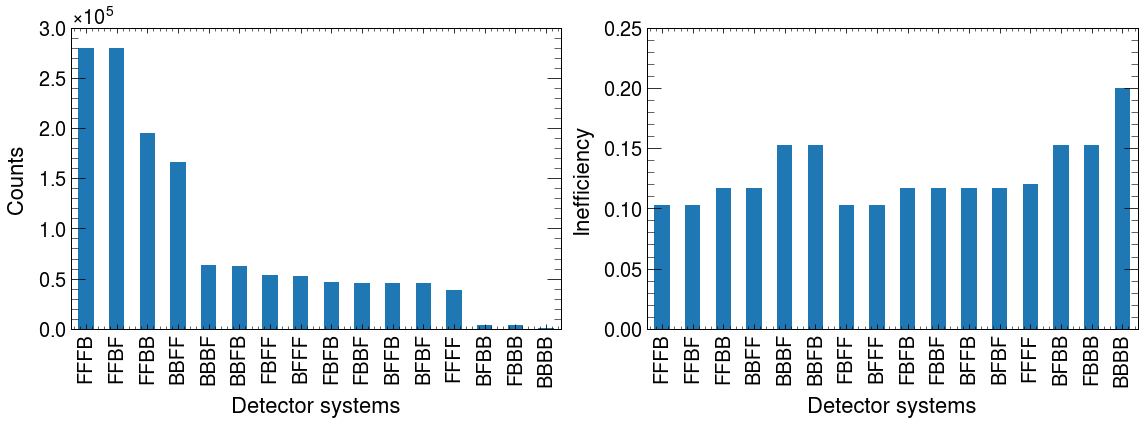

In [62]:
fig,axes=plt.subplots(1,2,figsize=(16,6))
fcal_bcal_counts.plot(kind='bar',ax=axes[0],color='tab:blue')
axes[0].set_ylabel('Counts')
axes[0].set_xlabel('Detector systems')
efficiencies.plot(kind='bar',ax=axes[1],color='tab:blue')
axes[1].set_ylabel('Inefficiency')
axes[1].set_xlabel('Detector systems')
plt.tight_layout()
plt.savefig("/d/grid17/ln16/dselector_v3/study_pwa/mass_dependent_fits/shared_results/systematic_nominal_v9/systematic_v24/fcal_efficiency.png")